# Quantum Pipeline:
using Lambeq

The quantum pipeline is very similar to the hybrid pipeline with one main difference in which instead of the classical pytorch trainer, a quantum trainer is used in cell 19.

For the quantum pipeline:
1. The sentences were extracted from 3 files into 1 file.
2. Some transformations like transforming sentences to diagrams and finding the accuracy were performed.
3. The results were loaded to log files and the result is saved in the notebook which was then uploaded to github.

In [1]:
%pip install lambeq
%pip install pytket-qiskit

In [2]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [3]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 10
SEED = 2

In [4]:
import glob

read_files = glob.glob("data/*.txt")

with open("data/sentences_file_result.txt", "wb") as outfile:
    for f in read_files:
        with open(f, "rb") as infile:
            outfile.write(infile.read())

In [5]:
with open("data/sentences_file_result.txt", "r", encoding="utf-8") as source_file:
    lines = source_file.readlines()[:80]

with open("data/sentences_file_result_train.txt", "w", encoding="utf-8") as output_file:
    output_file.writelines(lines)

In [6]:
with open("data/sentences_file_result.txt", "r", encoding="utf-8") as source_file:
    lines = source_file.readlines()[80:101]

with open("data/sentences_file_result_test.txt", "w", encoding="utf-8") as output_file:
    output_file.writelines(lines)

In [7]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('/content/data/sentences_file_result_train.txt')
val_labels, val_data = read_data('/content/data/sentences_file_result_test.txt')

In [8]:
import os

TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    val_labels, val_data = val_labels[:2], val_data[:2]
    EPOCHS = 1

In [9]:
train_data[:5]

['I am glad I took the leap of faith .',
 'I ordered May 31 .',
 'Thank you .',
 'Thank you .',
 'Thank you .']

In [10]:
train_labels[:5]

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]

In [11]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [12]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]

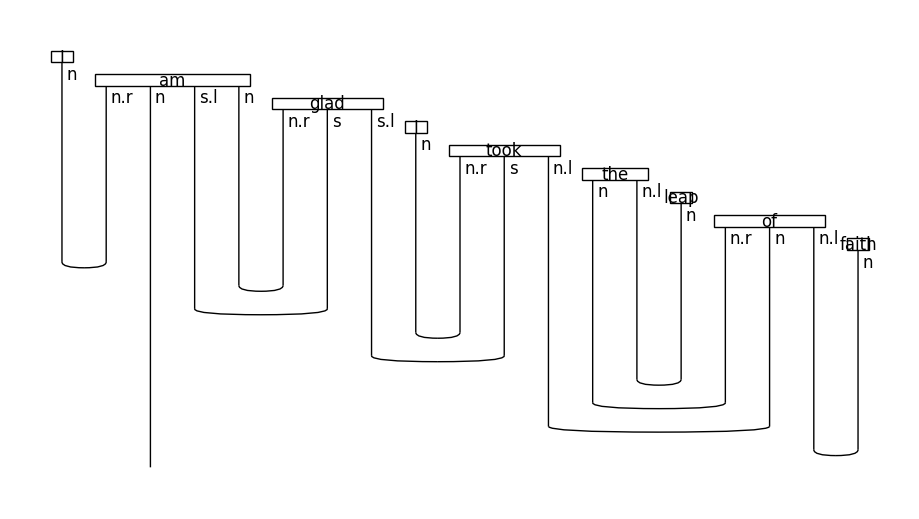

In [13]:
train_diagrams[0].draw(figsize=(9, 5), fontsize=12)

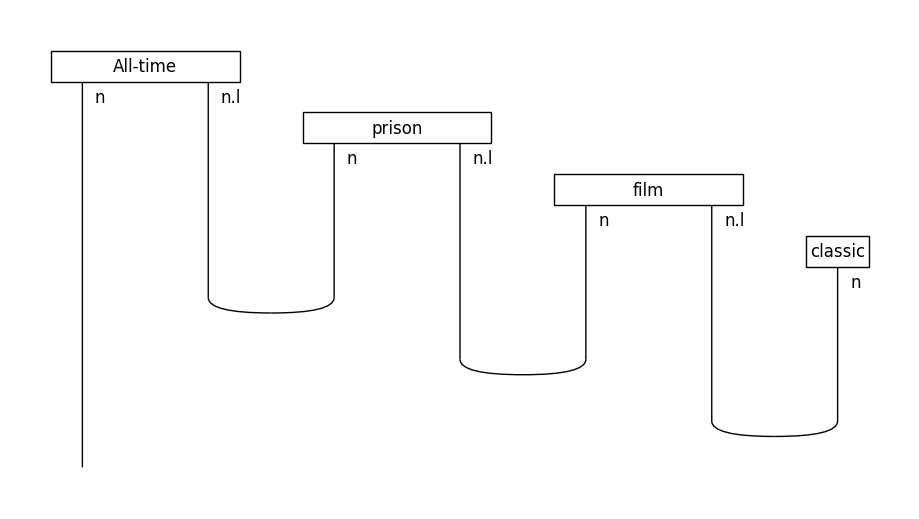

In [14]:
train_diagrams[-1].draw(figsize=(9, 5), fontsize=12)

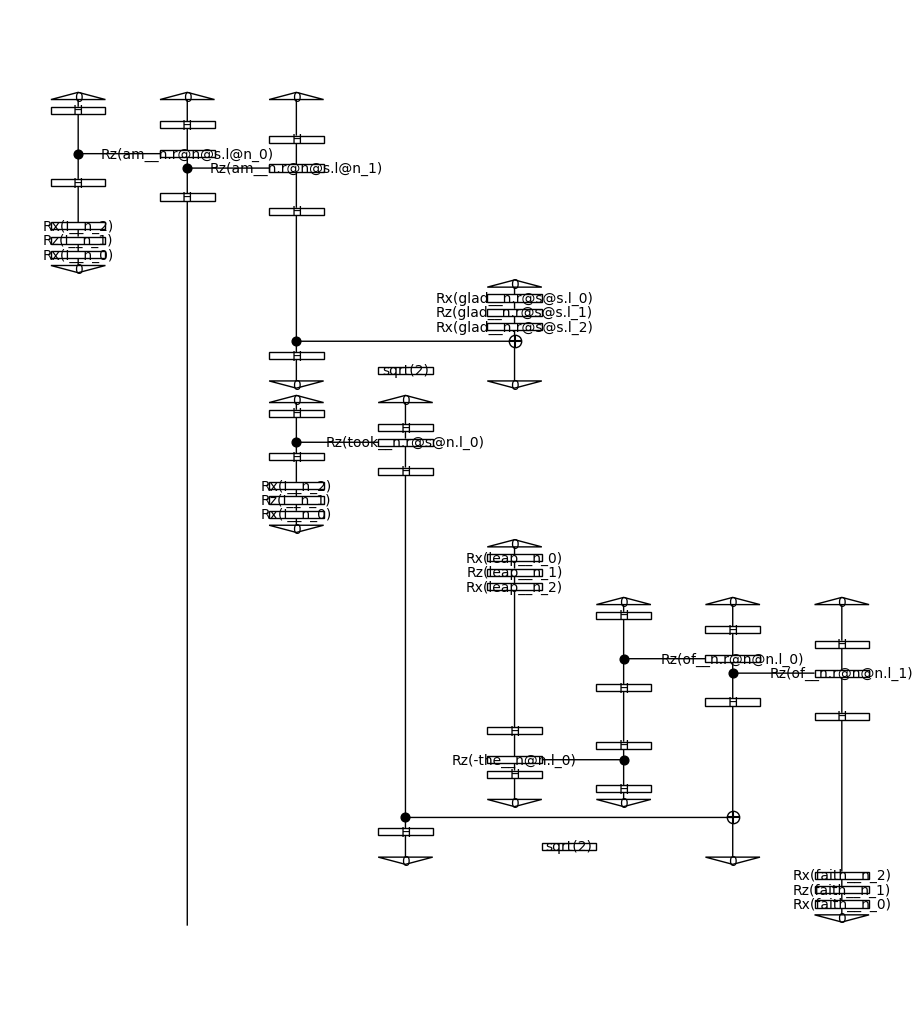

In [15]:
from lambeq import AtomicType, IQPAnsatz, remove_cups

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

train_circuits[0].draw(figsize=(9, 10))

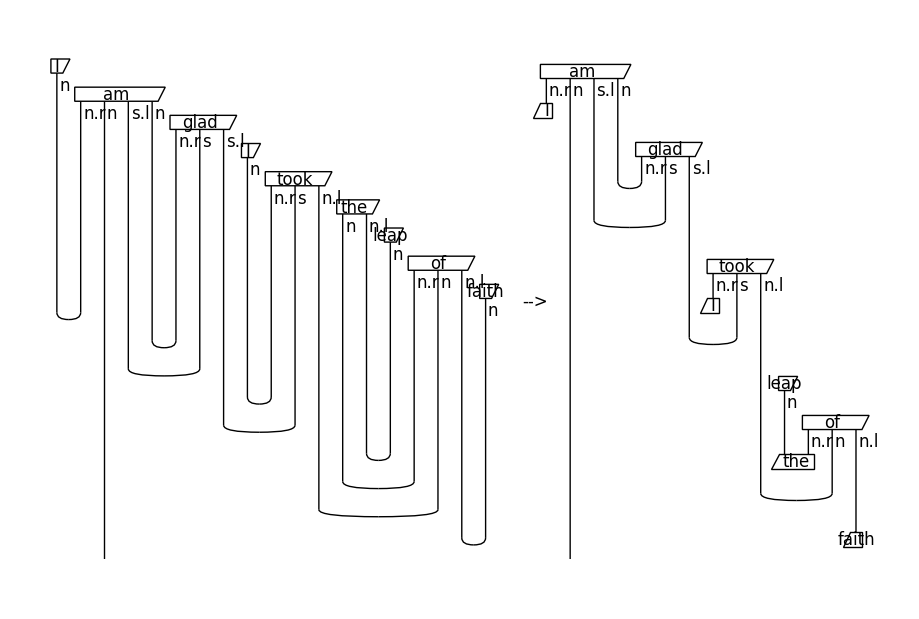

In [16]:
from discopy.drawing import Equation

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

Equation(original_diagram, removed_cups_diagram, symbol='-->').draw(figsize=(9, 6), asymmetry=0.3, fontsize=12)

In [17]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + val_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [18]:
from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

In [19]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)

In [20]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [21]:
trainer.fit(train_dataset, val_dataset, early_stopping_interval=7)

Epoch 1:   train/loss: 0.8688   valid/loss: 0.5280   train/acc: 0.5000   valid/acc: 0.6071
Epoch 2:   train/loss: 0.0527   valid/loss: 2.0284   train/acc: 0.4314   valid/acc: 0.6429
Epoch 3:   train/loss: 0.0036   valid/loss: 2.1177   train/acc: 0.6078   valid/acc: 0.5357
Epoch 4:   train/loss: 1.4722   valid/loss: 2.1988   train/acc: 0.5392   valid/acc: 0.4643
Epoch 5:   train/loss: 0.6365   valid/loss: 5.1119   train/acc: 0.5098   valid/acc: 0.3929
Epoch 6:   train/loss: 12.7718   valid/loss: 1.9300   train/acc: 0.5784   valid/acc: 0.6429
Epoch 7:   train/loss: 1.2196   valid/loss: 1.9347   train/acc: 0.5588   valid/acc: 0.6429
Epoch 8:   train/loss: 2.5644   valid/loss: 0.5781   train/acc: 0.6275   valid/acc: 0.5714
Early stopping!
Best model saved to RelPron/logs/best_model.lt

Training completed!


Validation accuracy: 0.5714285714285714


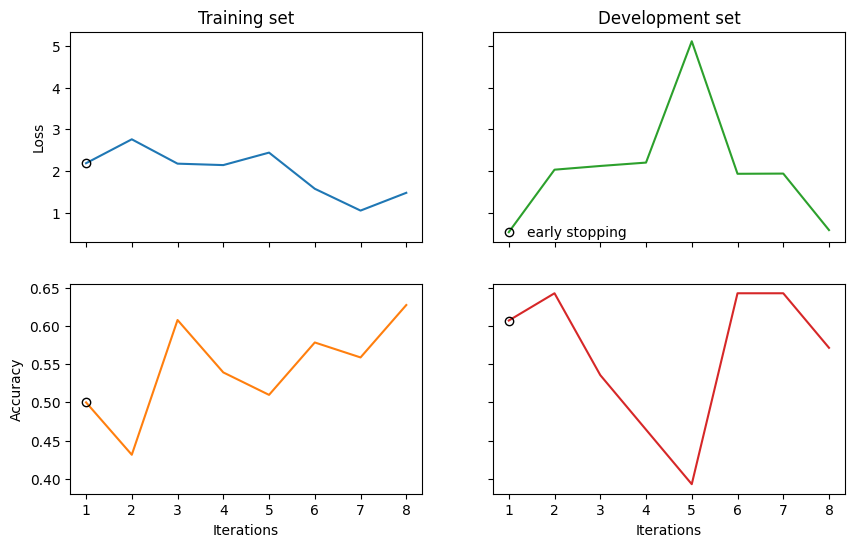

In [22]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, len(trainer.train_epoch_costs)+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# mark best model as circle
best_epoch = np.argmin(trainer.val_costs)
ax_tl.plot(best_epoch + 1, trainer.train_epoch_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_tr.plot(best_epoch + 1, trainer.val_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_bl.plot(best_epoch + 1, trainer.train_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')
ax_br.plot(best_epoch + 1, trainer.val_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')

ax_tr.text(best_epoch + 1.4, trainer.val_costs[best_epoch], 'early stopping', va='center')

# print test accuracy
model.load(trainer.log_dir + '/best_model.lt')
test_acc = acc(model(val_circuits), val_labels)
print('Validation accuracy:', test_acc.item())